In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy as np
import os

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 36.5 MB/s 
     |████████████████████████████████| 895 kB 44.8 MB/s 
     |████████████████████████████████| 596 kB 46.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 134 kB 31.4 MB/s 
     |████████████████████████████████| 212 kB 32.8 MB/s 
     |████████████████████████████████| 1.1 MB 45.6 MB/s 
     |████████████████████████████████| 127 kB 48.1 MB/s 
     |████████████████████████████████| 271 kB 43.3 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 144 kB 37.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/IT350/datasets/qa/qa.csv',names=['id','question','answer','label'],header=None)
# df = df.astype({'label':int})
df['label']=pd.to_numeric(df['label'])
del df["id"]
# print(df["label"].dtype)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.20)
train.to_csv('/content/drive/MyDrive/IT350/datasets/qa/train.csv',index=False)
test.to_csv('/content/drive/MyDrive/IT350/datasets/qa/test.csv',index=False)

In [ ]:
from datasets import load_dataset

In [ ]:
raw_dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/IT350/datasets/qa/train.csv',
                                              'test': '/content/drive/MyDrive/IT350/datasets/qa/test.csv'})

Using custom data configuration default-ff1a73a7085fae21


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ff1a73a7085fae21/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'label'],
        num_rows: 19668
    })
    test: Dataset({
        features: ['question', 'answer', 'label'],
        num_rows: 4917
    })
})

In [ ]:
df.dtypes

question    object
answer      object
label        int64
dtype: object

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
raw_dataset['train'].features

{'answer': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'question': Value(dtype='string', id=None)}

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["question"],examples["answer"],max_length=128, padding="max_length",truncation=True)
tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
type(tokenized_datasets['train'])

datasets.arrow_dataset.Dataset

In [ ]:
tokenized_datasets['test'][200]['input_ids'][111]

0

In [ ]:
def extract_features(tokenized_datasets,train_test):
  Y=[]
  X={'input_ids':[],'token_type_ids':[],'attention_mask':[]}
  for i in range(len(tokenized_datasets[train_test])):
    input_ids=tokenized_datasets[train_test][i]['input_ids']
    token_type_ids=tokenized_datasets[train_test][i]['token_type_ids']
    attention_mask=tokenized_datasets[train_test][i]['attention_mask']
    X['input_ids'].append(input_ids)
    X['token_type_ids'].append(token_type_ids)
    X['attention_mask'].append(attention_mask)
    Y.append(tokenized_datasets[train_test][i]['label'])
  X['input_ids']=np.array(X['input_ids'],dtype=np.int32)
  X['token_type_ids']=np.array(X['token_type_ids'],dtype=np.int32)
  X['attention_mask']=np.array(X['attention_mask'],dtype=np.int32)
  Y=np.array(Y,dtype=np.float32)
  return X,Y

In [ ]:
test_data,test_y=extract_features(tokenized_datasets,'test')
train_data,train_y=extract_features(tokenized_datasets,'train')

In [ ]:
import transformers
from transformers import TFBertModel
max_length=128
input_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="input_ids"
)
# Attention masks indicates to the model which tokens should be attended to.
attention_masks = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="attention_masks"
)
# Token type ids are binary masks identifying different sequences in the model.
token_type_ids = tf.keras.layers.Input(
    shape=(max_length,), dtype=tf.int32, name="token_type_ids"
)
# Loading pretrained BERT model.
bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
# Freeze the BERT model to reuse the pretrained features without modifying them.
bert_model.trainable = True

bert_output = bert_model(
    input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)
sequence_output = bert_output.last_hidden_state
pooled_output = bert_output.pooler_output
# Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
bi_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(sequence_output)
# Applying hybrid pooling approach to bi_lstm sequence output.
avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss="binary_crossentropy",
    metrics=["acc"],
)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',  

In [ ]:
input_data=[train_data['input_ids'],train_data['token_type_ids'],train_data['attention_mask']]
valid_data=[test_data['input_ids'],test_data['token_type_ids'],test_data['attention_mask']]
history=model.fit(input_data,train_y,validation_data=(valid_data,test_y),epochs=2)

Epoch 1/2
615/615 [==============================] - 1122s 2s/step - loss: 0.3560 - acc: 0.8325 - val_loss: 0.2471 - val_acc: 0.9028
Epoch 2/2
 40/615 [>.............................] - ETA: 15:41 - loss: 0.1904 - acc: 0.9328

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/IT350/models/BERT_QA_trainable_true/model.h5')

In [ ]:
val_data=[test_data['input_ids'],test_data['token_type_ids'],test_data['attention_mask']]
model.evaluate(val_data,test_y)

154/154 [==============================] - 86s 528ms/step - loss: 0.2082 - acc: 0.9174


[0.20824430882930756, 0.9174293279647827]

In [ ]:
from keras.models import load_model
model=load_model('/content/drive/MyDrive/IT350/models/BERT_QA/model.h5',custom_objects={'TFBertModel':TFBertModel})

In [ ]:
print(history.params)
print(history.history.keys())

NameError: ignored

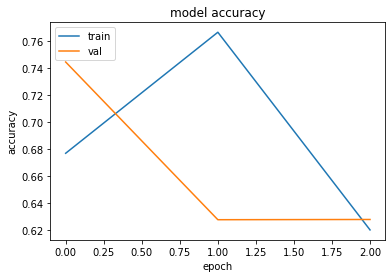

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()